In [234]:
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [235]:
from qiskit import *
from qiskit.pulse import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
import qiskit.pulse.pulse_lib as pulse_lib
import qiskit.tools.jupyter

In [236]:
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

/Users/pranavgokhale/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-ornl', group='bes-qis', project='argonne')>]

In [237]:
provider = IBMQ.get_provider(group='bes-qis')
backend = provider.get_backend('ibmq_boeblingen')
system = pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
defaults = backend.defaults()
cmd_def = pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=config.meas_map[0])

In [238]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='610px', min_width='610px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

-----

In [6]:
# qubit to use for exeperiment
control_qubit = 0
target_qubit = 1
uchannel = 0

# exp configuration
exps = 30
shots = 512

# Rabi pulse
cr_amps = np.linspace(0, 0.2, exps)
cr_samples = 200
cr_sigma = 4
cr_rise_fall = 16

In [7]:
# Calculate amplitude from complex signal
def get_amplitude(vec):
    i_signal = np.imag(vec)
    r_signal = np.real(vec)

    mvec = [np.mean(r_signal), np.mean(i_signal)]

    src_mat = np.vstack((r_signal - mvec[0], i_signal - mvec[1])).T
    (_, _, v_mat) = np.linalg.svd(src_mat)

    dvec = v_mat[0, 0:2]

    if dvec.dot(mvec) < 0:
        dvec = -dvec

    return src_mat.dot(dvec)


In [8]:
[control_qubit, target_qubit] in config.coupling_map

True

In [9]:
defaults.qubit_freq_est[control_qubit] > defaults.qubit_freq_est[target_qubit]

True

In [10]:
config.u_channel_lo[uchannel]

[UchannelLO(q=1, scale=(1+0j))]

In [11]:
# Create schedule
schedules = []
for ii, cr_amp in enumerate(cr_amps):
    # drive pulse
    cr_rabi_pulse_p = pulse_lib.gaussian_square(duration=cr_samples,
                                                amp=cr_amp,
                                                sigma=cr_sigma,
                                                risefall=cr_rise_fall,
                                                name='cr_rabi_pulse_p%d' % ii)
    cr_rabi_pulse_m = pulse_lib.gaussian_square(duration=cr_samples,
                                                amp=-cr_amp,
                                                sigma=cr_sigma,
                                                risefall=cr_rise_fall,
                                                name='cr_rabi_pulse_m%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='CR Rabi Experiment at drive amp = %s' % cr_amp)
    
    schedule |= cr_rabi_pulse_p(system.controls[uchannel])

    schedule |= cmd_def.get('x', qubits=[control_qubit]) << schedule.duration
    schedule |= cr_rabi_pulse_m(system.controls[uchannel]) << schedule.duration
    schedule |= measure << schedule.duration
 
    schedules.append(schedule)

In [12]:
cr_rabi_qobj = assemble(schedules, backend, meas_level=1, meas_return='avg', shots=shots)

In [13]:
job = backend.run(cr_rabi_qobj)
print(job.job_id())

5d93dd4dde3ef200180cf24c


In [14]:
job = backend.retrieve_job('5d93dd4dde3ef200180cf24c')

Text(0.5,1,'CR Rabi oscillation')

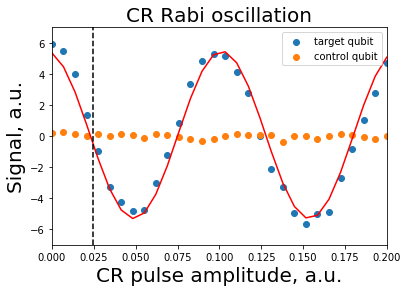

In [15]:
cr_rabi_result = job.result()
target_qubit_rabi_data = np.ones(exps, dtype=np.complex_)
control_qubit_rabi_data = np.ones(exps, dtype=np.complex_)


scale_factor=1e-10

for i in range(exps):
    target_qubit_rabi_data[i] = cr_rabi_result.get_memory(i)[target_qubit]*scale_factor
    control_qubit_rabi_data[i] = cr_rabi_result.get_memory(i)[control_qubit]*scale_factor
    
target_rabi_amp_data = get_amplitude(target_qubit_rabi_data)
control_rabi_amp_data = get_amplitude(control_qubit_rabi_data)

fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)

#Fit the data
fitparams, conv = scipy.optimize.curve_fit(fit_func, cr_amps, target_rabi_amp_data, [3.0,0.0,0.1,0])

#get the pi amplitude
cr_pi_2_amp = (np.pi-fitparams[3])*fitparams[2]/4/np.pi

plt.plot(cr_amps, fit_func(cr_amps, *fitparams), color='red')
plt.axvline(cr_pi_2_amp, color='black', linestyle='dashed')
plt.scatter(cr_amps, target_rabi_amp_data, label='target qubit')
plt.scatter(cr_amps, control_rabi_amp_data, label='control qubit')
plt.xlim(0, 0.2)
plt.ylim(-7, 7)
plt.legend()
plt.xlabel('CR pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('CR Rabi oscillation', fontsize=20)

In [16]:
cr_pi_2_amp

0.02450048659651925

In [29]:
cr_rabi_pulse_p = pulse_lib.gaussian_square(duration=cr_samples,
                                            amp=cr_pi_2_amp,
                                            sigma=cr_sigma,
                                            risefall=cr_rise_fall,
                                            name='cr_rabi_pulse_p%d' % ii)
cr_rabi_pulse_m = pulse_lib.gaussian_square(duration=cr_samples,
                                            amp=-cr_pi_2_amp,
                                            sigma=cr_sigma,
                                            risefall=cr_rise_fall,
                                            name='cr_rabi_pulse_m%d' % ii)

# add commands to schedule
schedule = pulse.Schedule(name='CR Rabi Experiment at drive amp = %s' % cr_amp)

schedule |= cr_rabi_pulse_p(system.controls[uchannel])
schedule |= cmd_def.get('x', qubits=[control_qubit]) << schedule.duration
schedule |= cr_rabi_pulse_m(system.controls[uchannel]) << schedule.duration
schedule |= cmd_def.get('u3', qubits=[target_qubit], P0 = np.pi/2, P1 = 3*np.pi/2, P2=np.pi/2) << schedule.duration
schedule |= measure << schedule.duration

In [30]:
job = execute(schedule, backend=backend, shots=shots)
print(job.job_id())

5d93bf48b99007001972c0bf


In [39]:
# applying X(pi/2) to target qubit. If it received a X(pi/2) rotation, we should see all |1>.
# if it received a X(-pi/2) rotation, we should see all |0>.
job = backend.retrieve_job('5d93bf48b99007001972c0bf')
counts = job.result().get_counts()
num_ones = sum([freq for (bitstring, freq) in counts.items() if ('000' + bitstring)[-2] == '1'])

In [40]:
num_ones/shots

0.443359375

In [34]:
shots

512

In [35]:
# aha, so it did a X(pi/2) rotation. That means we have a CR_pi/2 rotation indeed.

schedule = pulse.Schedule(name='CR Rabi Experiment at drive amp = %s' % cr_amp)

schedule |= cmd_def.get('u1', qubits=[control_qubit], P0=np.pi/2)
schedule |= cmd_def.get('u1', qubits=[target_qubit], P0=np.pi/2)

schedule |= cmd_def.get('u2', qubits=[target_qubit], P0=0, P1=np.pi) << schedule.duration  # H


schedule |= cmd_def.get('u3', qubits=[target_qubit], P0 = -np.pi/2, P1 = 3*np.pi/2, P2=np.pi/2) << schedule.duration  # Rx(-theta)

schedule |= cr_rabi_pulse_p(system.controls[uchannel]) << schedule.duration
schedule |= cmd_def.get('x', qubits=[control_qubit]) << schedule.duration
schedule |= cr_rabi_pulse_m(system.controls[uchannel]) << schedule.duration


schedule |= cmd_def.get('u2', qubits=[target_qubit], P0=0, P1=np.pi) << schedule.duration  # H

schedule |= measure << schedule.duration

In [36]:
job = execute(schedule, backend=backend, shots=shots)
print(job.job_id())

5d93da646afef300184e6d38


In [37]:

counts = job.result().get_counts()
num_ones = sum([freq for (bitstring, freq) in counts.items() if bitstring.endswith('1')])

KeyboardInterrupt: 

In [101]:
instructions = cmd_def.get('u1', qubits=[1], P0=2).instructions
for instruction in instructions:
    print(instruction[1].channels)

(ControlChannel(0),)
(DriveChannel(1),)
(ControlChannel(4),)
(ControlChannel(12),)


In [107]:
(cmd_def.get('cx', qubits=[0,1])).flatten().instructions

((0, FrameChange(fc0, phase=1.571)),
 (0, FrameChange(fc1, phase=1.571)),
 (0, SamplePulse(Ym_d0, duration=10)),
 (0, SamplePulse(X90p_d1, duration=10)),
 (10, SamplePulse(CR90p_u0, duration=21)),
 (10, SamplePulse(CR90p_d1, duration=50)),
 (60, SamplePulse(Xp_d0, duration=10)),
 (70, SamplePulse(CR90m_u0, duration=21)),
 (70, SamplePulse(CR90m_d1, duration=50)))

In [111]:
dir(pulse.Schedule())

['_Schedule__children',
 '__abstractmethods__',
 '__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lshift__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_buffer',
 '_children',
 '_filter',
 '_instructions',
 '_name',
 '_timeslots',
 'append',
 'buffer',
 'ch_duration',
 'ch_start_time',
 'ch_stop_time',
 'channels',
 'draw',
 'duration',
 'filter',
 'flatten',
 'insert',
 'instructions',
 'name',
 'shift',
 'start_time',
 'stop_time',
 'timeslots',
 'union']

In [131]:
for child in cmd_def.get('cx', qubits=[0, 1])._children:
    print(child)

(0, Schedule("name=cx", 0, (0, FrameChange(fc0, phase=1.571)), (0, FrameChange(fc1, phase=1.571)), (0, SamplePulse(Ym_d0, duration=10)), (0, SamplePulse(X90p_d1, duration=10)), (10, SamplePulse(CR90p_u0, duration=21)), (10, SamplePulse(CR90p_d1, duration=50)), (60, SamplePulse(Xp_d0, duration=10)), (70, SamplePulse(CR90m_d1, duration=50))))
(0, Schedule("name=CR90m_u0", 70, (70, SamplePulse(CR90m_u0, duration=21))))


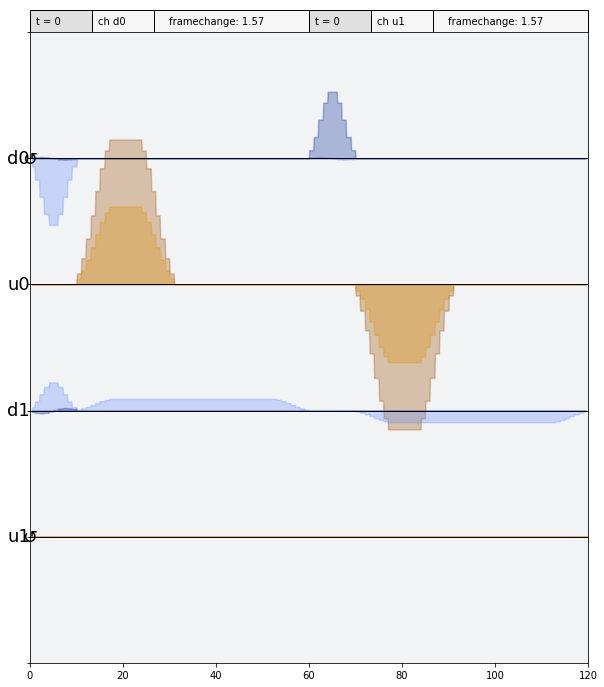

In [149]:
cmd_def.get('cx', qubits=[0,1]).draw(scaling=7)

In [179]:
schedule = 

AttributeError: can't set attribute

In [187]:
instructions[3][1].channels

(DriveChannel(1),)

In [239]:
def get_cr_schedule(theta=np.pi/2):
    """Effectively implements: 1-controlled RX(theta), 0-controlled RX(-theta)"""
    assert theta <= np.pi/2
    scaling_factor = theta / (np.pi/2)
    
    cx_schedule = cmd_def.get('cx', qubits=[0,1])
    assert len(cx_schedule.instructions) == 9
    
    cr_schedule = pulse.Schedule()

    offset = cx_schedule.instructions[4][0]
    for instruction in cx_schedule.instructions[4:]:
        command = instruction[1].command
        if 'CR' in command.name and 'u0' in command.name:
            command = SamplePulse(list(map(lambda sample: sample * scaling_factor, command.samples)))
        cr_schedule |= command(instruction[1].channels[0]) << (instruction[0] - offset)
        
    cr_schedule = cmd_def.get('x', qubits=[0]) + cr_schedule
    
    return cr_schedule

Annotated instructions:

FrameChange(fc0, phase=1.571)      --> Z(qubit0)

FrameChange(fc1, phase=1.571)      --> ignore--it affects control U(1), which is irrelevant

SamplePulse(Ym_d0, duration=10)    --> Y(qubit 0)

SamplePulse(X90p_d1, duration=10)  --> RX(90deg, qubit1)

---------------

Following sequence amounts to two CR pulses, one positive and one negative, separated by an X gate on qubit0.
Sliding the X gate on qubit 0 to the left, this sequence becomes equivalent to an X(qubit0) followed by a CR with double the magnitude (i.e. double the angular rotation) of the individual ones. The positive and negative CR pulses help cancel out non ZX term errors. Specifically, the implemented CR becomes RX(-90deg, qubit1) followed by open control (qubit0) NOT on qubit1.

SamplePulse(CR90p_u0, duration=21)

SamplePulse(CR90p_d1, duration=50)

SamplePulse(Xp_d0, duration=10)

SamplePulse(CR90m_u0, duration=21)

SamplePulse(CR90m_d1, duration=50)


In [223]:
schedule = get_cr_schedule(theta=np.pi/4)
schedule |= cmd_def.get('measure', qubits=config.meas_map[0]) << schedule.duration

In [226]:
job = execute(schedule, backend=backend, shots=1000)
print(job.job_id())

5d9504cf6afef300184e6fc2


In [244]:
job = backend.retrieve_job('5d9504cf6afef300184e6fc2')
counts = job.result().get_counts()
num_ones = sum([freq for (bitstring, freq) in counts.items() if ('000' + bitstring)[-2] == '1'])
print(num_ones/1000)  # should see about 14.6% (1-cos^2(pi/4/2)) fraction of ones

0.095


In [241]:
schedule = get_cr_schedule(theta=3*np.pi/8)
schedule |= cmd_def.get('measure', qubits=config.meas_map[0]) << schedule.duration

In [242]:
job = execute(schedule, backend=backend, shots=1000)
print(job.job_id())

Task exception was never retrieved
future: <Task finished coro=<WebsocketClient.get_job_status() done, defined at /Users/pranavgokhale/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/api_v2/clients/websocket.py:132> exception=None>
Traceback (most recent call last):
  File "/Users/pranavgokhale/anaconda3/lib/python3.7/asyncio/tasks.py", line 225, in __step
    result = coro.throw(exc)
  File "/Users/pranavgokhale/anaconda3/lib/python3.7/site-packages/websockets/protocol.py", line 684, in transfer_data
    yield from self._put_message_waiter
  File "/Users/pranavgokhale/anaconda3/lib/python3.7/asyncio/futures.py", line 260, in __await__
    yield self  # This tells Task to wait for completion.
concurrent.futures._base.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/pranavgokhale/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/api_v2/clients/websocket.py", line 175, in get_job_

5d956ed3a58023001908cc9d


In [245]:
job = backend.retrieve_job('5d956ed3a58023001908cc9d')
counts = job.result().get_counts()
num_ones = sum([freq for (bitstring, freq) in counts.items() if ('000' + bitstring)[-2] == '1'])
print(num_ones/1000)  # should see about 14.6% (1-cos^2(pi/4/2)) fraction of ones

0.18


In [246]:
schedule = get_cr_schedule()
schedule |= cmd_def.get('measure', qubits=config.meas_map[0]) << schedule.duration

In [247]:
job = execute(schedule, backend=backend, shots=1000)
print(job.job_id())

5d957474a58023001908cc9f


In [248]:
job = backend.retrieve_job('5d957474a58023001908cc9f')
counts = job.result().get_counts()
num_ones = sum([freq for (bitstring, freq) in counts.items() if ('000' + bitstring)[-2] == '1'])
print(num_ones/1000)  # should see about 14.6% (1-cos^2(pi/4/2)) fraction of ones

0.267
